### **Milestone Deliverable Two**

__In this deliverable we primarily focus performance comparison of 3 different algorithms which will be using HER to learn environment intricacies to achieve the final goal of parking the agent.__

### **Setting up the environment**

* __Downgrading tensorflow for `stable-baselines` support.__
* __Installing `highway-env` & `stable-baselines`.__
* __Setting up virtual display for google colab.__
* __Importing plotting and progress measurement packages.__



In [1]:
# Downgrading tensorflow version for compatability with stable-baselines package.
# stable-baselines hasn't been made compatible with Tensorflow-2.0.
# Hence, it can't be used directly with Tensorflow version installed in Colab.
! pip install tensorflow==1.15.3
# After this restart runtime and print the version output of tensorflow.

     |████████████████████████████████| 110.5MB 36kB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 3.8MB 39.6MB/s 
     |████████████████████████████████| 512kB 35.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=47bce660920b60c4ba67da4555a6777a8b857864755e3a4bc9c8112b3735c11a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [2]:
# Confirming that the model version has downgraded from Tensorflow-2.0
import tensorflow as tf
print(tf.__version__)
# Output: 1.15.3

1.15.3


In [3]:
# Package download statements.
# Note 1: This time we also use ffmpeg package for handling video recording related tasks.
# Note 2: The package version are generic and doesn't require any specific package version downloads.
!pip install git+https://github.com/eleurent/highway-env
!apt-get update
!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

# Agent related import statements.
!pip install stable-baselines[mpi] --upgrade
# Restart runtime one more time for mpi4py package setup.

  Cloning https://github.com/eleurent/highway-env to /tmp/pip-req-build-ga0reglp
  Running command git clone -q https://github.com/eleurent/highway-env /tmp/pip-req-build-ga0reglp
     |████████████████████████████████| 11.4MB 273kB/s 
  Created wheel for highway-env: filename=highway_env-1.0.dev0-cp36-none-any.whl size=81225 sha256=c2466295745b86be80d2cb8965254036daba6c619714cec1223cfed68891b2fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-8fh0yyjd/wheels/e6/10/d8/02a077ca221bbac1c6fc12c1370c2f773a8cd602d4be3df0cc
Successfully built highway-env
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 htt

In [4]:
# importing gym and high_env for loading different environment scenarios.
import gym
import numpy as np
import highway_env

# Comparison between performance of three different algorithms with same parameters.
from stable_baselines import HER, SAC, DDPG, TD3
# tqdm: gives progress bars to loops.
from tqdm.notebook import trange

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [36]:
# plotting the comparitive graph for different agents under analysis.
import matplotlib.pyplot as plt

In [52]:
# Similar, to earlier rendering procedures for creating virtual display.
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
from pathlib import Path
import base64

# Declaing display screen size for rendering highway-env environment.
display = Display(visible=0, size=(1366, 768))
display.start()

# These functions are also available in '/highway-env/scripts/' directory in utils.py
# file of highway-env github repository. These, can be directly accessed with below
# commands but we are using these functions here to fix a specific size of recorded videos.
# Note: commands are stated below for directly using these functions.
# Also, we have changed these functions slightly. Therefore, refer documentation.

# !git clone https://github.com/eleurent/highway-env.git
# import sys
# sys.path.insert(0, './highway-env/scripts/')
# from utils import record_videos, show_videos, capture_intermediate_frames

def wrap_env(env):
    '''
    Monitoring the environment interactions by agent and recording them in video.
    '''
    return Monitor(env, './video', force=True, video_callable=lambda episode: True)


def show_video():
    '''
    Reading the stored video and display the output inline with code cells.
    '''
    html = []
    for mp4 in Path('./video').glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 212px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def capture_intermediate_frames(env):
    '''
    Sending rendered frames to Monitor for logging video recording of captured frame.
    '''
    env.unwrapped.automatic_rendering_callback = env.video_recorder.capture_frame

### **SAC Agent Training with HER Wrapper function**

In [27]:
env = gym.make("parking-v0")
# SAC parses the model class of Off-Policy RL model.
# 'MlpPolicy' implements actor-critic with a MLP (2 layers of 64 nodes).
sac_model = HER('MlpPolicy', env, SAC, n_sampled_goal=4,
            goal_selection_strategy='future',
            verbose=1, buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.9, batch_size=256,
            policy_kwargs=dict(layers=[256, 256, 256]))
# argument: total_timesteps is passed as approximately 33k.
# It gives number of timestamps to train on.
sac_model.learn(16384)

------------------------------------------
| current_lr              | 0.001        |
| ent_coef                | 0.0038123555 |
| ent_coef_loss           | -0.92403686  |
| entropy                 | 1.3093061    |
| episodes                | 100          |
| fps                     | 16           |
| mean 100 episode reward | -41.8        |
| n_updates               | 9489         |
| policy_loss             | 2.1340132    |
| qf1_loss                | 0.004185785  |
| qf2_loss                | 0.004470771  |
| success rate            | 0.07         |
| time_elapsed            | 591          |
| total timesteps         | 9588         |
| value_loss              | 0.003367655  |
------------------------------------------


### **SAC Agent Evaluation with Average Reward Calculation**

In [28]:
env = gym.make("parking-v0")
# creating reward_list for storing all the rewards
sac_rewards = []
for episode in trange(100, desc="Calculating Average Reward Values"):
    obs, done = env.reset(), False
    rewards = 0.0
    while not done:
        action, _ = sac_model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards = rewards + reward
    # Storing the reward function trend values.
    sac_rewards.append(rewards)
env.close()
# Storing the average value of rewards in 
avg_sac_rewards = (sum(sac_rewards)/100)

print(sac_rewards)
print(avg_sac_rewards)


[-11.312161377034398, -36.705603182749236, -27.282886887624755, -15.94561702625338, -38.15928897097739, -29.910885080227757, -22.17468221066607, -21.566356345859983, -22.3384145485686, -31.6115549208558, -16.671028178260144, -34.51956607341075, -16.219033375158048, -4.074943087538648, -24.54867372963317, -17.557048708070166, -43.815591762818705, -24.988031303202995, -27.67683300762491, -21.207282113901112, -42.43582189856385, -23.964202729622457, -26.44165423699981, -4.123747257004673, -4.1185103846175135, -29.509746598752965, -19.91091854949616, -42.451070725604374, -23.768560684720438, -12.382510157729302, -39.07318660869807, -22.95064753618713, -15.06353127407962, -26.951653166313456, -23.086763951634516, -31.264481730778368, -26.770826102999873, -3.963437156446511, -23.65106762827569, -12.783876057757812, -22.759439527389127, -25.03838091090901, -20.010907471450977, -43.36197171170546, -24.640091154287735, -38.57452933921621, -13.559786307924323, -38.76018260097039, -7.72325927676

### **DDPG Agent Training with HER Wrapper function**

In [29]:
env = gym.make("parking-v0")
ddpg_model = HER('MlpPolicy', env, DDPG, n_sampled_goal=4,
            goal_selection_strategy='future',
            verbose=1, buffer_size=int(1e6),
            gamma=0.9, batch_size=256,
            policy_kwargs=dict(layers=[256, 256, 256]))
ddpg_model.learn(16384)

--------------------------------------
| reference_Q_mean        | -1.55    |
| reference_Q_std         | 1.18     |
| reference_action_mean   | -0.1     |
| reference_action_std    | 0.822    |
| reference_actor_Q_mean  | -1.52    |
| reference_actor_Q_std   | 1.18     |
| rollout/Q_mean          | -1.18    |
| rollout/actions_mean    | 0.00792  |
| rollout/actions_std     | 0.631    |
| rollout/episode_steps   | 100      |
| rollout/episodes        | 100      |
| rollout/return          | -62.2    |
| rollout/return_history  | -62.2    |
| success rate            | 0        |
| total/duration          | 416      |
| total/episodes          | 100      |
| total/epochs            | 1        |
| total/steps             | 9998     |
| total/steps_per_second  | 24.1     |
| train/loss_actor        | 1.44     |
| train/loss_critic       | 0.0112   |
| train/param_noise_di... | 0        |
--------------------------------------



### **DDPG Agent Evaluation with Average Reward Calculation**

In [30]:
env = gym.make("parking-v0")
ddpg_rewards = []
for episode in trange(100, desc="Calculating Average Reward Values"):
    obs, done = env.reset(), False
    rewards = 0.0
    while not done:
        action, _ = ddpg_model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards = rewards + reward
    # Storing the reward function trend values.
    ddpg_rewards.append(rewards)
env.close()
# Storing the average value of rewards in 
avg_ddpg_rewards = (sum(ddpg_rewards)/100)

print(ddpg_rewards)
print(avg_ddpg_rewards)


[-33.42074973766248, -34.0331770552391, -47.16845203735596, -49.81724739563149, -65.46642228159423, -58.17920143197229, -78.28169021168759, -21.598632749999705, -70.26991763091351, -75.40295577133882, -50.971322462709615, -54.30745042309471, -37.72939893512516, -25.950238597522915, -29.079520577877012, -36.559759110831436, -75.85053951899133, -78.12434273871587, -41.746121817048355, -38.65768982842152, -35.9541069974983, -77.72915469706928, -25.25129021880864, -43.11049415471838, -36.602447664718596, -76.9322735023769, -23.99502904715731, -40.422460755099934, -18.745512731842638, -35.59108155112675, -33.106804460462826, -49.75369200702383, -41.41006493364131, -53.043972144154935, -38.68461708274798, -34.71995633490038, -36.813401202099925, -45.189893792906354, -49.871335531573024, -40.48520094919924, -46.82519235445386, -30.650399411833988, -34.76707412125102, -27.93935783091568, -37.494079046377415, -51.30058150942724, -40.434740344446844, -31.15934288988025, -77.91458388754573, -25.

### **TD3 Agent Training with HER Wrapper function**

In [31]:
env = gym.make("parking-v0")
td3_model = HER('MlpPolicy', env, TD3, n_sampled_goal=4,
            goal_selection_strategy='future',
            verbose=1, buffer_size=int(1e6),
            gamma=0.9, batch_size=256,
            policy_kwargs=dict(layers=[256, 256, 256]))
td3_model.learn(16384)

-----------------------------------------
| current_lr              | 0.0003      |
| episodes                | 100         |
| fps                     | 19          |
| mean 100 episode reward | -56         |
| n_updates               | 9800        |
| qf1_loss                | 0.030584045 |
| qf2_loss                | 0.029856429 |
| success rate            | 0.02        |
| time_elapsed            | 495         |
| total timesteps         | 9833        |
-----------------------------------------


### **TD3 Agent Evaluation with Average Reward Calculation**

In [32]:
env = gym.make("parking-v0")
td3_rewards = []
for episode in trange(100, desc="Calculating Average Reward Values"):
    obs, done = env.reset(), False
    rewards = 0.0
    while not done:
        action, _ = td3_model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards = rewards + reward
    # Storing the reward function trend values.
    td3_rewards.append(rewards)
env.close()
# Storing the average value of rewards in 
avg_td3_rewards = (sum(td3_rewards)/100)

print(td3_rewards)
print(avg_td3_rewards)


[-16.70658371689911, -20.533141493945788, -27.367342174006684, -25.331773240407472, -23.974405456208366, -55.55742410946709, -25.231465574744917, -39.025337167065445, -20.11080978847671, -35.32366914086179, -27.19167322420737, -26.769444114869707, -27.517976827147493, -36.58991634882953, -38.897706565987036, -50.846975833385706, -55.75648382395356, -38.771599281600565, -58.66044912282905, -58.48590707871155, -48.621352525169, -50.01874697087444, -35.56921116971998, -34.062254425733386, -31.22079026139644, -48.56688173105211, -35.95523004925129, -23.474410478149153, -40.862897522137814, -40.52220373375081, -42.979926317096044, -19.16261744102802, -26.898424090210273, -23.51837001672098, -25.876286293676255, -55.24004231739749, -38.44653450227506, -21.11343242628631, -42.71196311969729, -27.9639169966857, -55.760380939060504, -50.6457947285107, -37.659735249956995, -46.765559273451565, -37.72303933567855, -55.20250392743457, -27.685311780824126, -36.78206547260535, -35.01787418301349, -

### **Plotting the reward values for all the agents trained**

In [34]:
 # decleration of variables for graph creation.
 lower = 0
 upper = 100
 length = 100
 num_len = [lower + x*(upper-lower)/length for x in range(length)]
 print(num_len)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


In [43]:
# Average plot line creation for graph population.
from itertools import repeat
avg_td3_rewards_list = []
avg_sac_rewards_list = []
avg_ddpg_rewards_list = []

avg_td3_rewards_list.extend(repeat(avg_td3_rewards, 100)) 
avg_ddpg_rewards_list.extend(repeat(avg_ddpg_rewards, 100)) 
avg_sac_rewards_list.extend(repeat(avg_sac_rewards, 100)) 

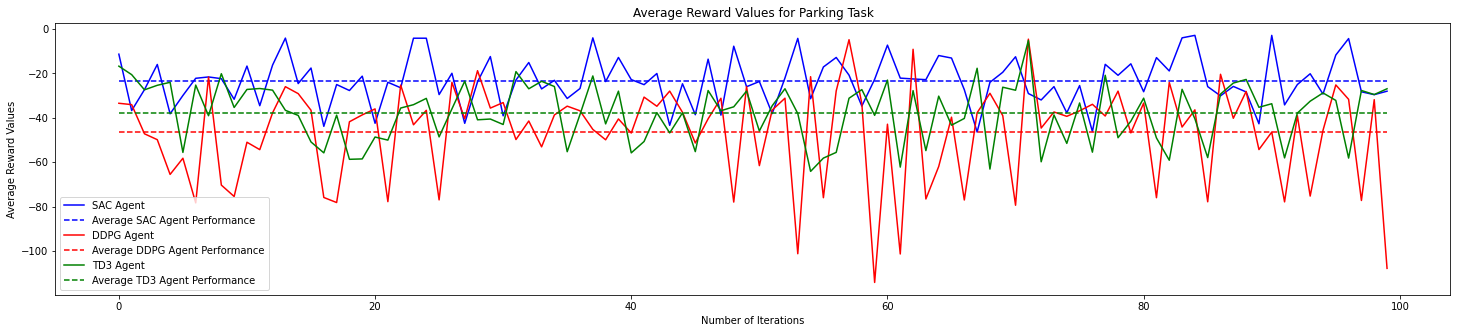

In [50]:
# Plotting the reward results after model training.
plt.figure(figsize=(25,5))

plt.plot(num_len, sac_rewards, label='SAC Agent', color="blue")
plt.plot(num_len, avg_sac_rewards_list, '--', label='Average SAC Agent Performance', color="blue")
plt.plot(num_len, ddpg_rewards, label='DDPG Agent', color="red")
plt.plot(num_len, avg_ddpg_rewards_list, '--', label='Average DDPG Agent Performance', color="red")
plt.plot(num_len, td3_rewards, label='TD3 Agent', color="green")
plt.plot(num_len, avg_td3_rewards_list, '--', label='Average TD3 Agent Performance', color="green")

plt.xlabel('Number of Iterations')
plt.ylabel('Average Reward Values')
plt.title('Average Reward Values for Parking Task')
plt.legend()

plt.show()

### **Displaying the video outputs of the problem and downloading them**

In [53]:
env = wrap_env(gym.make("parking-v0"))
# Running sample 10 episodes for video output.
for episode in trange(10, desc="Output Episodes for SAC Agent"):
    # capture_intermediate_frames is inside the loop
    # With this we can capture multiple iterations of goal completion
    # into our Monitor instance.
    obs, done = env.reset(), False
    capture_intermediate_frames

    while not done:
        action, _ = sac_model.predict(obs)
        obs, reward, done, info = env.step(action)

env.close()

In [54]:
show_video()

In [55]:
# zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# downloading the file resource.
from google.colab import files
files.download("/content/file.zip")
!rm -r video/

  adding: content/video/ (stored 0%)
  adding: content/video/openaigym.video.3.100.video000003.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000000.mp4 (deflated 6%)
  adding: content/video/openaigym.video.3.100.video000002.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000006.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000007.mp4 (deflated 18%)
  adding: content/video/openaigym.video.3.100.video000000.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000007.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000008.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000004.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000004.mp4 (deflated 6%)
  adding: content/video/openaigym.video.3.100.video000001.meta.json (deflated 60%)
  adding: content/video/openaigym.video.3.100.video000002.mp4 (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
env = wrap_env(gym.make("parking-v0"))
# Running sample 10 episodes for video output.
for episode in trange(10, desc="Output Episodes for DDPG Agent"):
    # capture_intermediate_frames is inside the loop
    # With this we can capture multiple iterations of goal completion
    # into our Monitor instance.
    obs, done = env.reset(), False
    capture_intermediate_frames

    while not done:
        action, _ = ddpg_model.predict(obs)
        obs, reward, done, info = env.step(action)

env.close()

In [58]:
show_video()

In [ ]:
# zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# downloading the file resource.
from google.colab import files
files.download("/content/file.zip")
!rm -r video/

In [61]:
env = wrap_env(gym.make("parking-v0"))
# Running sample 10 episodes for video output.
for episode in trange(10, desc="Output Episodes for TD3 Agent"):
    # capture_intermediate_frames is inside the loop
    # With this we can capture multiple iterations of goal completion
    # into our Monitor instance.
    obs, done = env.reset(), False
    capture_intermediate_frames

    while not done:
        action, _ = td3_model.predict(obs)
        obs, reward, done, info = env.step(action)

env.close()

In [62]:
show_video()

In [ ]:
# zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# downloading the file resource.
from google.colab import files
files.download("/content/file.zip")
!rm -r video/

__Note: All the models are not trained extensively for this experiment to observe the performance of each RL algorithm in an intermediate state. As a learner you can tune the timestamp & other hyperparameters to achieve an optimum performance for our trained agents.__